# Titanic - Classification

In [315]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder, OneHotEncoder, LabelBinarizer

from sklearn_pandas import DataFrameMapper

from IPython.display import display, HTML

## Read the Titanic dataset

In [268]:
TRAIN_PATH = "datasets/train.csv"
TEST_PATH = "datasets/test.csv"
DESCR_PATH = "datasets/description.txt"

In [269]:
def read_titanic_data(path):
    return pd.read_csv(path, index_col=0)

train = read_titanic_data(TRAIN_PATH)
test = read_titanic_data(TEST_PATH)

## Preprocessing

Titanic dataset contains information about passengers. The aim is to predict which passengeres survived. Each sample is one passenger. Below you can find description of each feature.

In [270]:
with open(DESCR_PATH,'r') as f:
    descr = f.read()
print(descr)

Data Dictionary

Variable	Definition					Key
survival	Survival					0 = No, 1 = Yes
pclass		Ticket class					1 = 1st, 2 = 2nd, 3 = 3rd
sex		Sex	
Age		Age in years	
sibsp		# of siblings / spouses aboard the Titanic	
parch		# of parents / children aboard the Titanic	
ticket		Ticket number	
fare		Passenger fare	
cabin		Cabin number	
embarked	Port of Embarkation				C = Cherbourg, Q = Queenstown, S = Southampton


Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


In [271]:
display(train.head(),
        test.head())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Make PassengerId the main index of the dataset.

There are 891 samples of training dataset. It is not a lot.

In [272]:
print(len(train), len(test))

891 418


Below we can notice that Cabin feature has more than 75% missing values. Probably it is pointless to use this feature in analysis.

In [273]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [274]:
num_cols = ["Age", 
            "Fare", 
            "Parch", 
            "SibSp"
           ]
cat_cols = ["Pclass", 
            #"Name",                  #works better without Name
            "Sex", 
            "Ticket", 
            "Embarked"
           ]

Lets focus on histograms and description of numerical features. 

Passengers or titanic were mostly people between 20-35 years old. We can notice the peak in the Age between 20-25years old. There were also a lot of very young kids. Except of this we can notice that values of Age are going lower and lower on the left and right slope of the histogram. We can see also that most of people travelled without parents of children and without siblings and spouses. Analysis of the Fare feauture gives us information that people took mostly cheap tickets. We can notice values also very high ~ 500. It can be outlier. There are no strong correlations between numerical features.

In [275]:
train[num_cols].describe()

,Age,Fare,Parch,SibSp
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,0.523008
std,14.526497,49.693429,0.806057,1.102743
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,0.000000,1.000000
max,80.000000,512.329200,6.000000,8.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024ACAFE97F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000024ACB0B1E48>]], dtype=object)

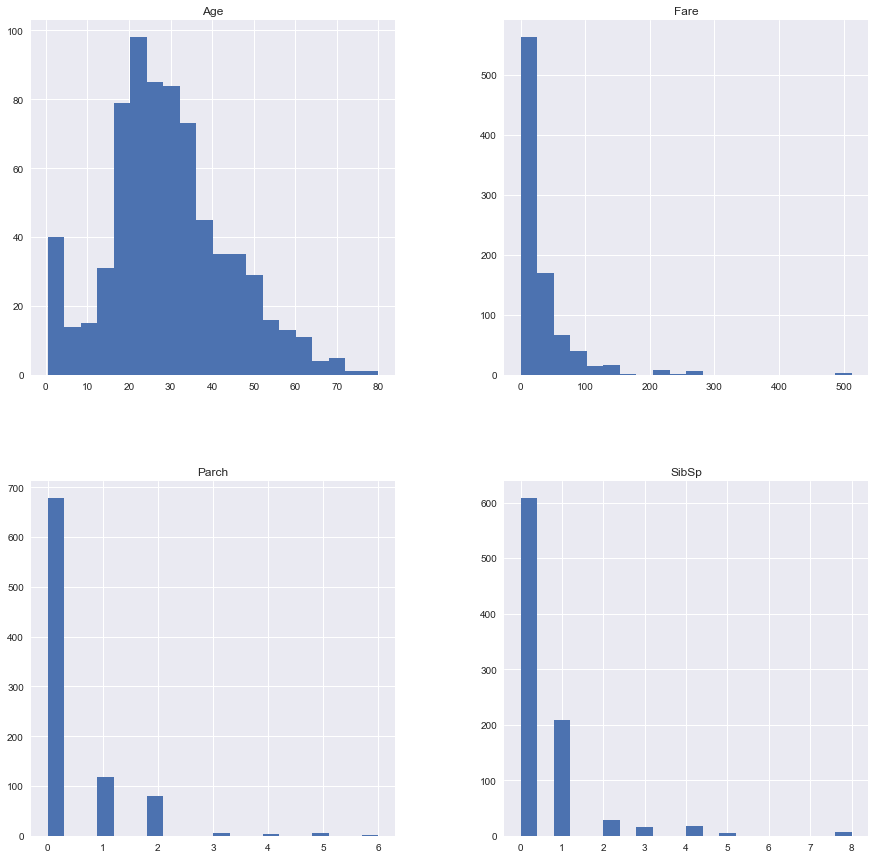

In [276]:
train[num_cols].hist(bins=20, figsize=(15,15))

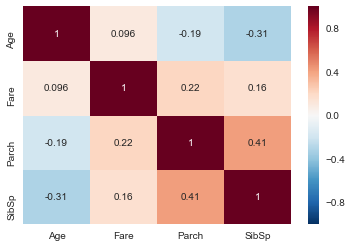

In [277]:
corr_matrix = train[num_cols].corr()
sns.heatmap(corr_matrix, annot=True)

Lets focus on categorical variables. 55% of passenger travelled third class. 21% second and 24% first. 65% of passsengers were male. All of the names in the dataset are unique. There are some tickets with the same name for different passengers.

In [279]:
display(train["Pclass"].value_counts(normalize=True),
        train["Sex"].value_counts(normalize=True),
        train["Embarked"].value_counts(normalize=True),
        #train["Name"].value_counts(),
        train["Ticket"].value_counts())

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

male      0.647587
female    0.352413
Name: Sex, dtype: float64

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

CA. 2343              7
1601                  7
347082                7
347088                6
3101295               6
CA 2144               6
382652                5
S.O.C. 14879          5
W./C. 6608            4
113760                4
2666                  4
LINE                  4
PC 17757              4
17421                 4
113781                4
4133                  4
347077                4
19950                 4
349909                4
F.C.C. 13529          3
SC/Paris 2123         3
347742                3
PC 17572              3
371110                3
13502                 3
24160                 3
29106                 3
345773                3
35273                 3
C.A. 34651            3
                     ..
17465                 1
2685                  1
34218                 1
4137                  1
SOTON/OQ 392090       1
19952                 1
2624                  1
29103                 1
2671                  1
PC 17475              1
SC/PARIS 2146   

As we can notice, it was possible to have one ticket for a few people, friends, relatives etc.

In [280]:
display(train.loc[train['Ticket'] == "1601"],
        train.loc[train['Ticket'] == "382652"],
        train.loc[train['Ticket'] == "LINE"])


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.125,NaN,Q
172,0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29.125,NaN,Q
279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.125,NaN,Q
788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.125,NaN,Q
886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.125,NaN,Q


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S


Remove target feature from the dataset.

In [281]:
X_train = train.drop(["Survived"], axis=1)
y_train = train["Survived"].copy()

62% of peaople died.

In [282]:
y_train.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Additional classes

Class which selects part of DF based on given columns.

In [283]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Class which changes NaN values of each feauture with its most frequent value.

In [284]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.apply(lambda x:x.fillna(x.value_counts().index[0]))
        return X

Class which apply LabelBinarizer on a few columns of DF.

In [285]:
class LabelBinarizerForMultipleColumns(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        transforms = []
        for column in X:
            transforms.append((column,[LabelBinarizer()]))
        mapper = DataFrameMapper(transforms)
        return mapper.fit_transform(X)

In [286]:
class ChangeNameIntoSurname(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        splitted = X.loc[:, 'Name'].str.split()
        X["Surname"] = splitted.str[0]
        X=X.drop(["Name"],axis=1)
        return X
        

In [287]:
class RemoveFareOutliers(BaseEstimator, TransformerMixin):
    def init(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.loc[X["Fare"] < 300].copy()

## Pipelines

For numerical features we do impuring NaN with median values. Then standard scaling is made.

For categorical features we imput NaN with most frequen values. Then apply LabelBinarizer for all columns.

Final data is prepared after applying both pipelines on the train data.

In [288]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_cols)),
    #('fare_outliers_remover', RemoveFareOutliers()),
    ("imputer", Imputer(strategy="most_frequent")),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_cols)),
    #('surname_adder', ChangeNameIntoSurname()),
    ('imputer', MostFrequentImputer()),
    ('encoder', LabelBinarizerForMultipleColumns(cat_cols))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [289]:
data = pd.concat([X_train, test])
data_prepared= full_pipeline.fit_transform(data)
X_train_prepared = data_prepared[:891]
test_prepared = data_prepared[891:]

In [290]:
X_train_prepared[0]

array([-0.51172249, -0.5031762 , -0.4449995 ,  0.48128777,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## Classifiers

### SGDClassifier (Binary Classifier)

Let's check results of applying SGDClassifier on the data.

In [291]:
sgd_clf = SGDClassifier(random_state=40)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=40, shuffle=True, verbose=0,
       warm_start=False)

Random chosen prediction is good.

In [292]:
display(sgd_clf.predict(X_train_prepared[2].reshape(1,-1)),
        y_train.head())

array([1], dtype=int64)

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

Cross validation says that 70%-85% of classifications were made good.

In [293]:
cross_val_score(sgd_clf, X_train_prepared, y_train, cv=10, scoring="accuracy")

array([ 0.81111111,  0.74444444,  0.74157303,  0.66292135,  0.78651685,
        0.76404494,  0.7752809 ,  0.76404494,  0.83146067,  0.76136364])

Confusion matrix says that there were 116 deaths predicted as survived and 114 survived predicted as deaths. 433 deaths and 228 survived were predicted correctly.

In [294]:
y_train_pred = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[397, 152],
       [102, 240]])

Results give precision and recall score very similiar. In titanic case we can decide that more important is to have higher recall score, because it seems to be more important to save more people who did't die and pick up also some dead bodies from the water. So increasing recall decreases amount of people who survived but were assumed to be dead. But increasing recall is followoing by decreasing precision, so we will have more dead people predicted as survivals. We can increase recall by decreasing threshold.

In [295]:
display(precision_score(y_train, y_train_pred),
        recall_score(y_train, y_train_pred),
        f1_score(y_train, y_train_pred))

0.61224489795918369

0.70175438596491224

0.65395095367847411

In [296]:
y_scores = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3, method = "decision_function")

In [297]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Now we have threshold equals to zero. As we can notice precision and recall have both values around 65.

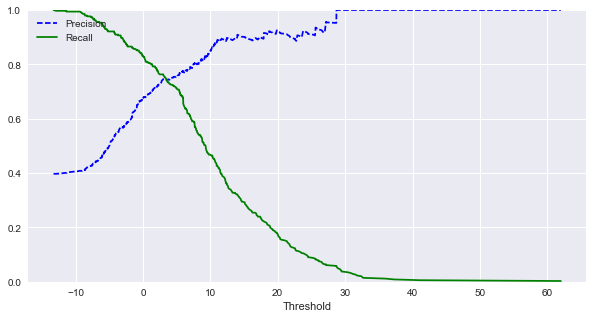

In [298]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

This plot shows that increasing recall decreases precision and vice versa. With recall value wanted as 0.8 we will have precision below level of 0.6.

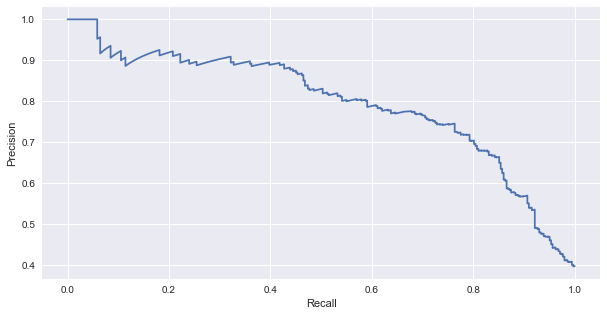

In [299]:
plt.figure(figsize=(10,5))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")

Lets see how change precision when we want to have 0.9 of recall score. 0.9 recall means that we considered 0.9 people who survied as survivals and only 0.1 of them as dead people.

In [300]:
y_train_pred_90 = (y_scores > -10) #-10 is level of the threshold at the first plot, with this level we have ~0.9 recall

So with 0.9 of recall we consider 0.9 of survived as survived but also 0.51 of dead people as survived. So it is more or less like lottery.

In [301]:
display(recall_score(y_train, y_train_pred_90),
        precision_score(y_train, y_train_pred_90))

0.99415204678362568

0.40572792362768495

Time to come back to threshold = 0.
Roc curve is another estimator of predictions. Closer curve is to the line, worse classificator is.

In [302]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

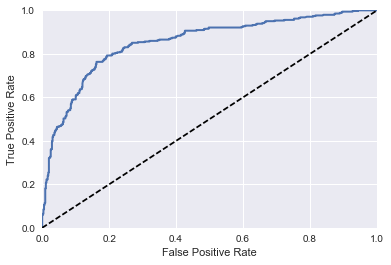

In [303]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr, thresholds)

It seems that more or less 0.8 predictions were made ok.

In [304]:
roc_auc_score(y_train, y_scores)

0.85287444476400476

### Random Forest Classifier

Another classifier to compare results. This one is not binary classifier.

In [305]:
forest_clf = RandomForestClassifier(random_state=40)
y_probas_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

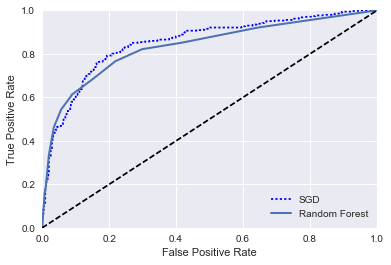

In [306]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

This classifier gives better results. But still not good enough.

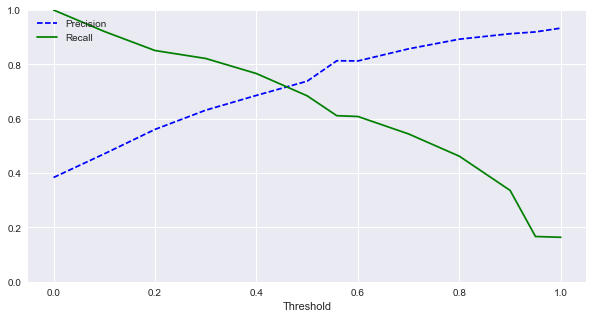

In [307]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_scores_forest)
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)

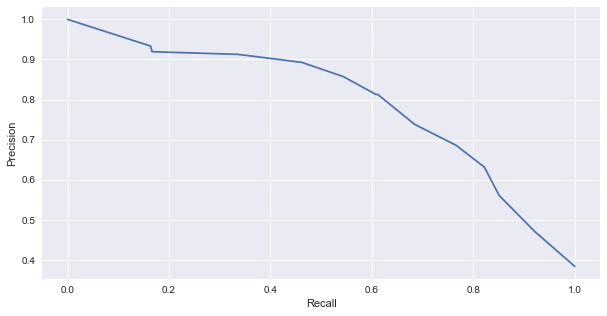

In [308]:
plt.figure(figsize=(10,5))
plt.plot(recalls_forest, precisions_forest)
plt.xlabel("Recall")
plt.ylabel("Precision")

In [309]:
y_train_pred = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=5)

In [310]:
cross_val_score(forest_clf, X_train_prepared, y_train, cv=5, scoring="accuracy")

array([ 0.77094972,  0.80446927,  0.8258427 ,  0.80337079,  0.81355932])

In [311]:
cross_val_score(sgd_clf, X_train_prepared, y_train, cv=5, scoring="accuracy")

array([ 0.75418994,  0.75418994,  0.62921348,  0.75280899,  0.68361582])

Precision score is higher but recall score is lower. Also roc_auc_score is lower. 

In [312]:
display(precision_score(y_train,  y_train_pred),
        recall_score(y_train, y_train_pred),
        roc_auc_score(y_train, y_train_pred))

0.81992337164750961

0.6257309941520468

0.77006039689387407

## Final predictions

In [313]:
forest_clf.fit(X_train_prepared, y_train)
predictions = forest_clf.predict(test_prepared)
final_predictions = pd.DataFrame(predictions, index=test.index, columns=["Survived"])
final_predictions.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [314]:
final_predictions.to_csv("results.csv")

After uploading results to Kaggle. I got score equal to 0.75. It is weak. I need to work more with this task.